<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/CRVEff/SectorEff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [2]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
from scipy.interpolate import interp1d
!pip install uncertainties
from uncertainties import ufloat, unumpy

%pip -q install uproot3
%pip -q install --upgrade tables
import uproot3

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'root_files_dzhadan')
import math

!pip install fsspec
import dask.dataframe as dd

S = pow(100*100, 2) #100x100 m2 in cm2 - simulated area

     |████████████████████████████████| 98 kB 3.3 MB/s 
     |████████████████████████████████| 117 kB 4.9 MB/s 
     |████████████████████████████████| 87 kB 5.5 MB/s 
     |████████████████████████████████| 5.9 MB 4.3 MB/s 
Mounted at /content/drive
     |████████████████████████████████| 133 kB 5.1 MB/s 


In [3]:
!pip install -I git+https://github.com/oksuzian/mu2etools.git
from mu2etools import utils, cuts

  Cloning https://github.com/oksuzian/mu2etools.git to /tmp/pip-req-build-35j621af
  Running command git clone -q https://github.com/oksuzian/mu2etools.git /tmp/pip-req-build-35j621af
  Created wheel for mu2etools: filename=mu2etools-0.0.1-py3-none-any.whl size=5911 sha256=f4109abd8ad580b7aeeabd6daf0205818ac93eeed7790bf4bf9357a8bcbefd01
  Stored in directory: /tmp/pip-ephem-wheel-cache-mer_76t1/wheels/00/92/a8/d2a2c55928a20d8675652a7135b8880f1f4f9b655d8885d452
Successfully built mu2etools


In [4]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 1.0
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

#Plot CRY4

In [5]:
try:
    dfCRY4
except NameError:
    dfCRY4 = pd.read_hdf(main_path + "root_files_cry4/cry4df.h5")

Text(0.5, 1.0, 'T3')

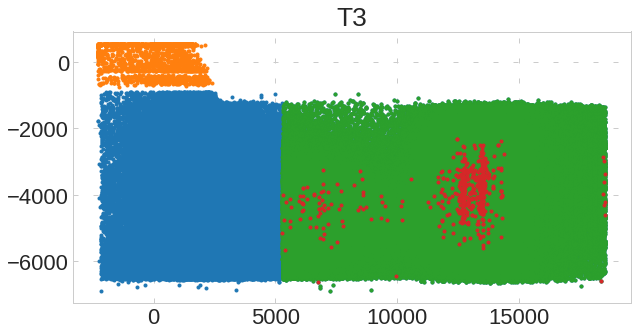

In [6]:
dftmp = dfCRY4.query('_z>-80000 & abs(_pdgId)==13 & lyield==17000')
plt.plot(dftmp.query('_crvSectorType==3')._z, dftmp.query('_crvSectorType==3')._x, '.');
plt.plot(dftmp.query('_crvSectorType==4')._z, dftmp.query('_crvSectorType==4')._x, '.');

plt.plot(dftmp.query('_crvSectorNumber==10')._z, dftmp.query('_crvSectorNumber==10')._x, '.');
plt.plot(dftmp.query('_crvSectorNumber==10 & crvinfo__timeWindowStart<0')._z, dftmp.query('_crvSectorNumber==10 & crvinfo__timeWindowStart<0')._x, '.');
plt.title('T3')

Text(0.5, 1.0, 'T4')

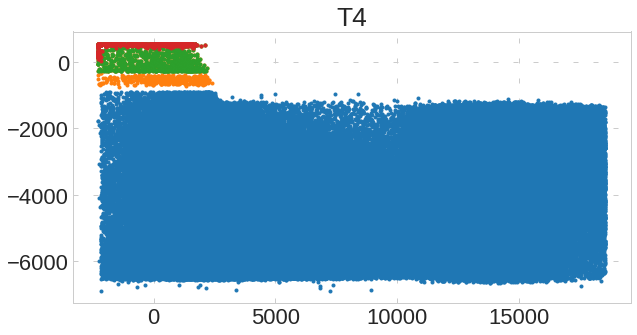

In [7]:
dftmp = dfCRY4.query('_z>-80000 & abs(_pdgId)==13 & lyield==17000')
plt.plot(dftmp.query('_crvSectorType==3')._z, dftmp.query('_crvSectorType==3')._x, '.');
plt.plot(dftmp.query('_crvSectorType==4')._z, dftmp.query('_crvSectorType==4')._x, '.');

plt.plot(dftmp.query('_crvSectorNumber==11')._z, dftmp.query('_crvSectorNumber==11')._x, '.');
plt.plot(dftmp.query('_crvSectorNumber==11 & crvinfo__timeWindowStart<0')._z, dftmp.query('_crvSectorNumber==11 & crvinfo__timeWindowStart<0')._x, '.');
plt.title('T4')

Text(0.5, 1.0, 'T2')

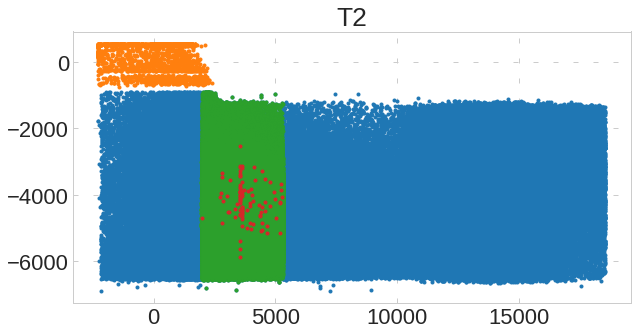

In [8]:
plt.plot(dftmp.query('_crvSectorType==3')._z, dftmp.query('_crvSectorType==3')._x, '.');
plt.plot(dftmp.query('_crvSectorType==4')._z, dftmp.query('_crvSectorType==4')._x, '.');

plt.plot(dftmp.query('_crvSectorNumber==9')._z, dftmp.query('_crvSectorNumber==9')._x, '.', label='T3');
plt.plot(dftmp.query('_crvSectorNumber==9 & crvinfo__timeWindowStart<0')._z, dftmp.query('_crvSectorNumber==9 & crvinfo__timeWindowStart<0')._x, '.');
plt.title('T2')

Text(0.5, 1.0, 'T1')

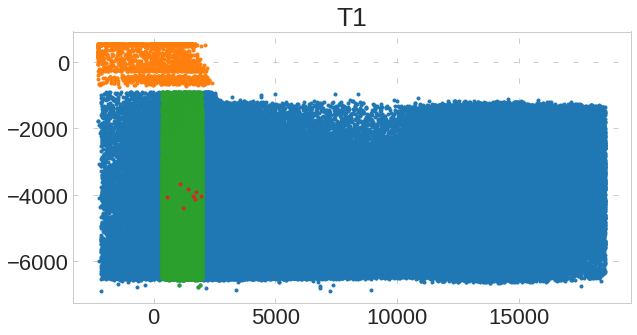

In [9]:
plt.figure()
plt.plot(dftmp.query('_crvSectorType==3')._z, dftmp.query('_crvSectorType==3')._x, '.');
plt.plot(dftmp.query('_crvSectorType==4')._z, dftmp.query('_crvSectorType==4')._x, '.');
plt.plot(dftmp.query('_crvSectorNumber==8')._z, dftmp.query('_crvSectorNumber==8')._x, '.', label='T3');
plt.plot(dftmp.query('_crvSectorNumber==8 & crvinfo__timeWindowStart<0')._z, dftmp.query('_crvSectorNumber==8 & crvinfo__timeWindowStart<0')._x, '.');
plt.plot(dftmp.query(cuts.cut_pid_trkqual_ue+'& _crvSectorNumber==8 & crvinfo__timeWindowStart<0')._z, dftmp.query(cuts.cut_pid_trkqual_ue+'& _crvSectorNumber==8 & crvinfo__timeWindowStart<0')._x, 'o');
plt.title('T1')

In [10]:
def getInefficiency(crvSectorNumber, cut):
  print('Working on sector: %d'%crvSectorNumber)
  ineff=[]
  ineffErr=[]
  lyield=[]
  for ly in range(7000, 17001, 2000): # loop through light yield values
    all, all_err, _, _, _, _ = utils.getNormBackground(dfCRY4, cut+'& abs(_pdgId)==13 & lyield==%d & _crvSectorNumber==%d'%(ly, crvSectorNumber), 1)
    nonvetoed, nonvetoed_err, _, _, _, _ = utils.getNormBackground(dfCRY4, cut+'& abs(_pdgId)==13 & crvinfo__timeWindowStart<0 & lyield==%d & _crvSectorNumber==%d'%(ly, crvSectorNumber), 1)

    if all==0:
      all = 1

    all = ufloat(all, math.sqrt(all))
    nonvetoed = ufloat(nonvetoed, math.sqrt(nonvetoed))
    ineff.append(unumpy.nominal_values(nonvetoed/all))
    ineffErr.append(unumpy.std_devs(nonvetoed/all))
    lyield.append(ly*utils.LYIELD_SCALE)
  return lyield, ineff, ineffErr, unumpy.nominal_values(all), unumpy.nominal_values(nonvetoed)

In [11]:
dfIneff = pd.DataFrame()
crvSectorNames = list(utils.CRV_SECTOR_NAMES_V7.keys())
for crvSectorNumber in range(0,21):
  crvSectorName = crvSectorNames[crvSectorNumber]

  lyield, ineff, ineffErr, all, nonvetoed = getInefficiency(crvSectorNumber, cuts.cut_nomom)
  ineff_dict = {'lyield':lyield,
                'ineff':ineff,
                'ineffErr':ineffErr,
                'all':all,
                'nonvetoed':nonvetoed,                
                }
  df_ = pd.DataFrame(ineff_dict)
  df_['crvSectorNumber']=crvSectorNumber
  df_['crvSectorName']=crvSectorName
  df_['cut']='No mom cut'
  dfIneff = dfIneff.append(df_, ignore_index = True)


  lyield, ineff, ineffErr, all, nonvetoed = getInefficiency(crvSectorNumber, 'True')
  ineff_dict = {'lyield':lyield,
                'ineff':ineff,
                'ineffErr':ineffErr,
                'all':all,
                'nonvetoed':nonvetoed,                
                }
  df_ = pd.DataFrame(ineff_dict)
  df_['crvSectorNumber']=crvSectorNumber
  df_['crvSectorName']=crvSectorName
  df_['cut']='No cuts'
  dfIneff = dfIneff.append(df_, ignore_index = True)

Working on sector: 0
Working on sector: 0
Working on sector: 1
Working on sector: 1
Working on sector: 2
Working on sector: 2
Working on sector: 3
Working on sector: 3
Working on sector: 4
Working on sector: 4
Working on sector: 5
Working on sector: 5
Working on sector: 6
Working on sector: 6
Working on sector: 7
Working on sector: 7
Working on sector: 8
Working on sector: 8
Working on sector: 9
Working on sector: 9
Working on sector: 10
Working on sector: 10
Working on sector: 11
Working on sector: 11
Working on sector: 12
Working on sector: 12
Working on sector: 13
Working on sector: 13
Working on sector: 14
Working on sector: 14
Working on sector: 15
Working on sector: 15
Working on sector: 16
Working on sector: 16
Working on sector: 17
Working on sector: 17
Working on sector: 18
Working on sector: 18
Working on sector: 19
Working on sector: 19
Working on sector: 20
Working on sector: 20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


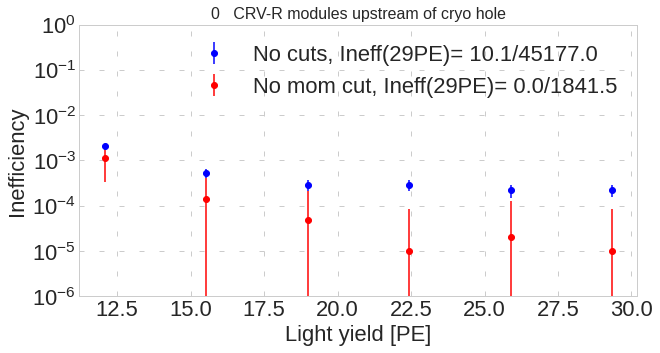

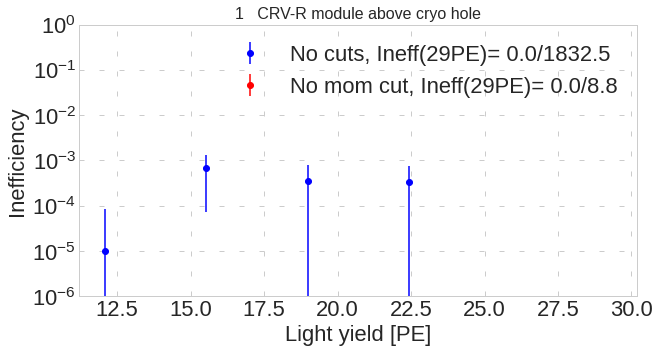

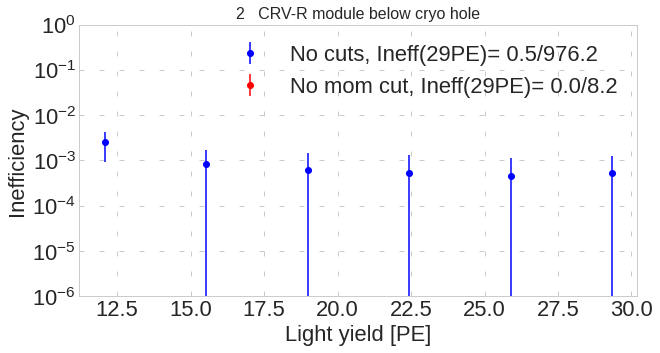

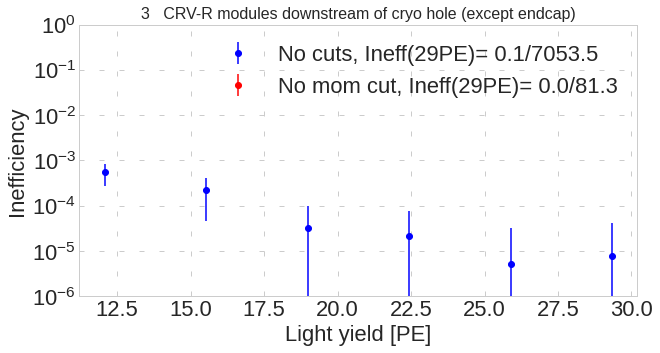

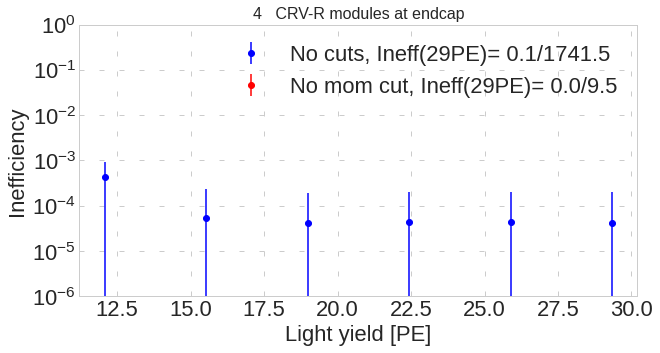

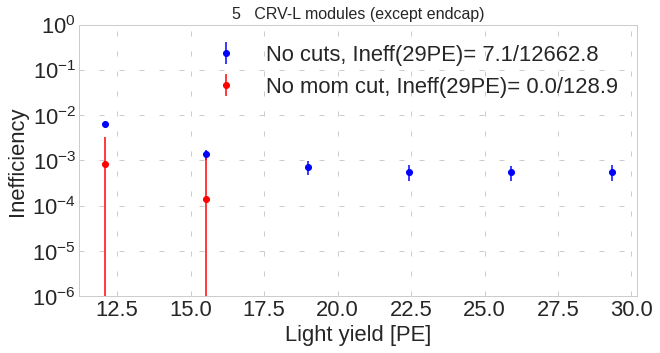

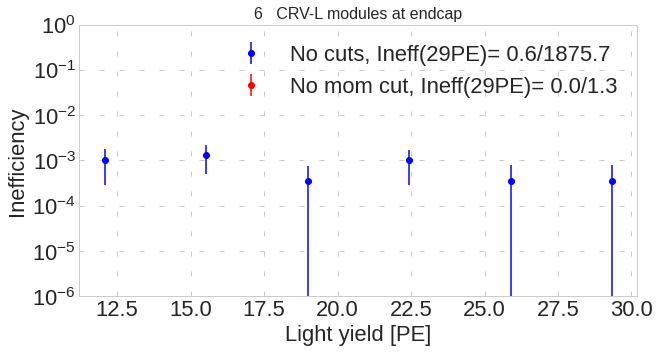

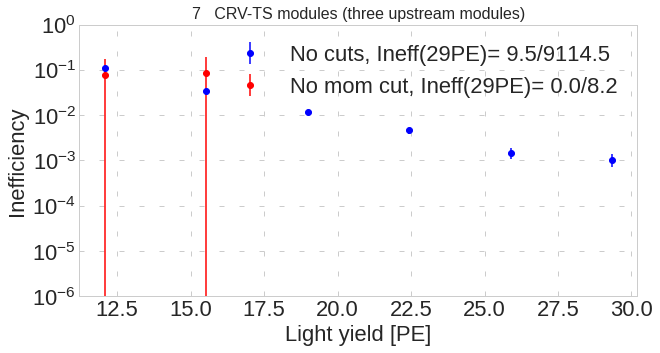

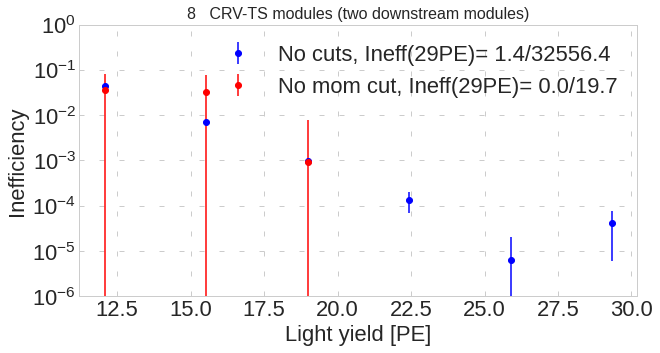

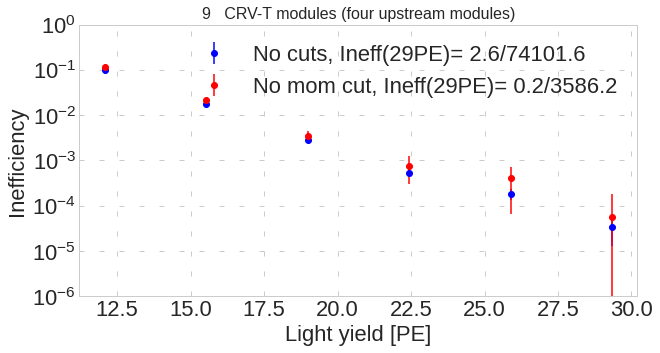

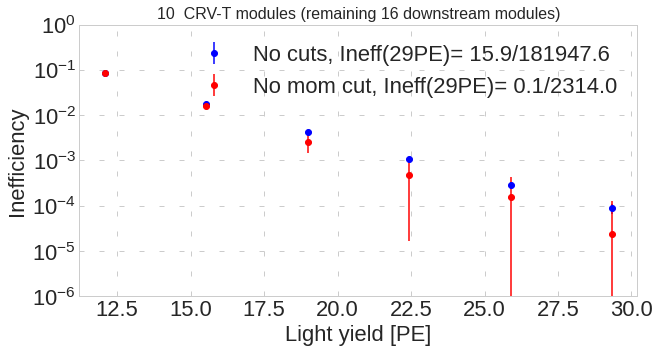

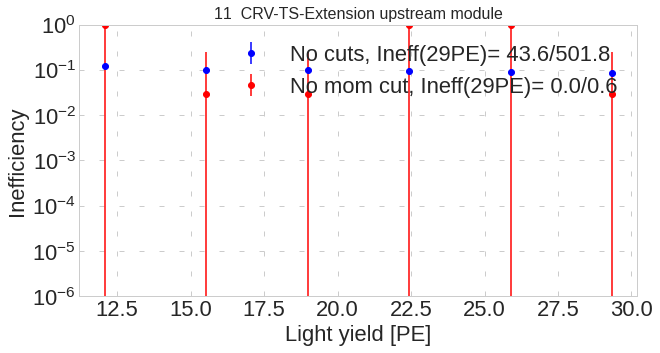

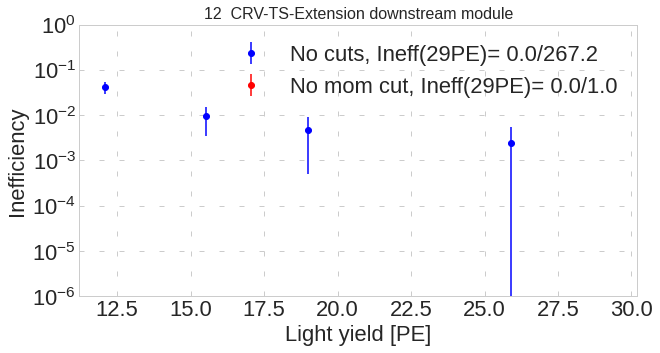

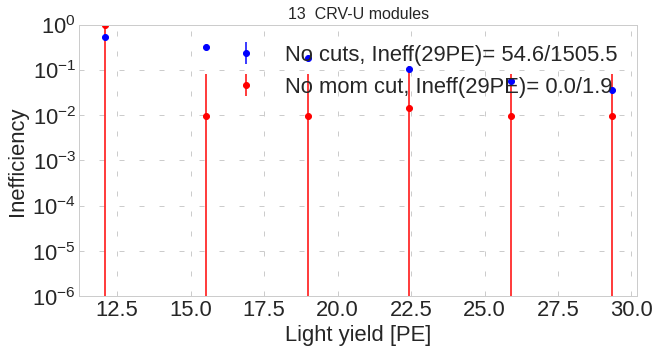

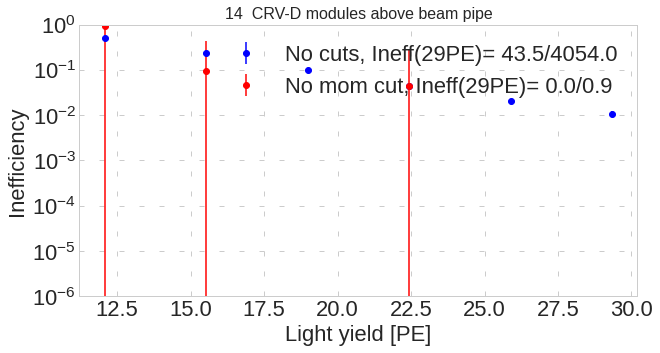

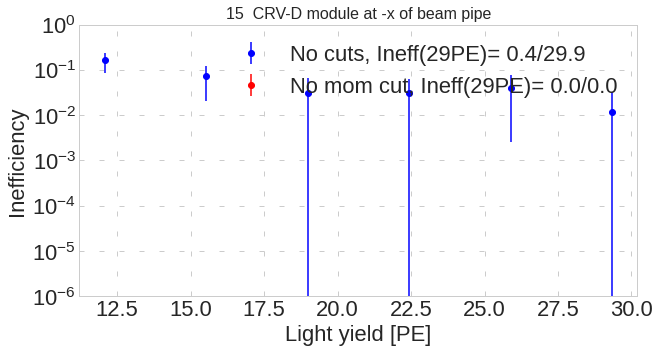

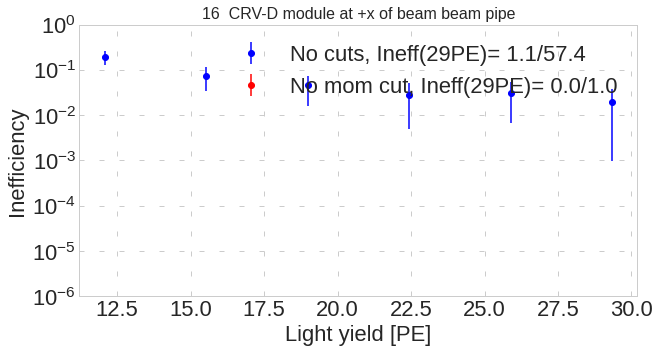

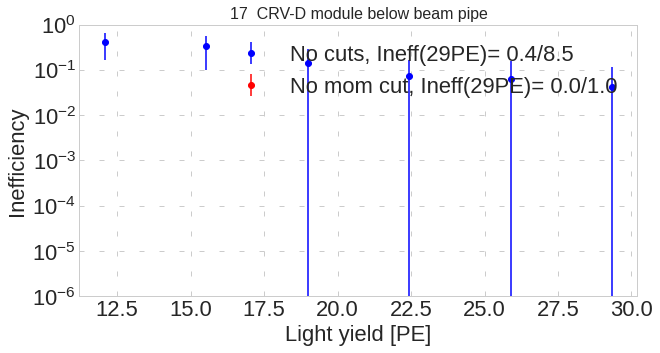

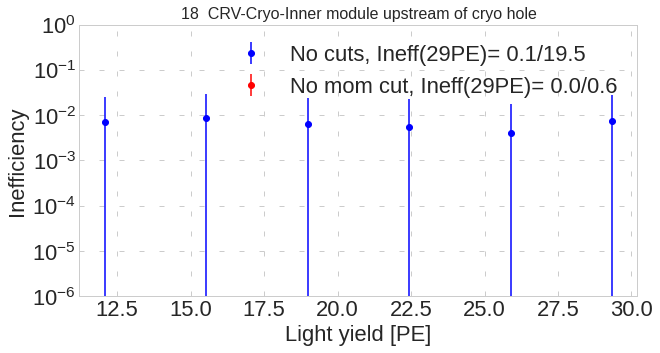

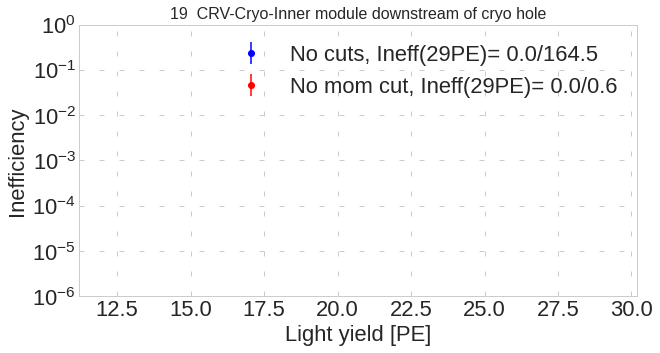

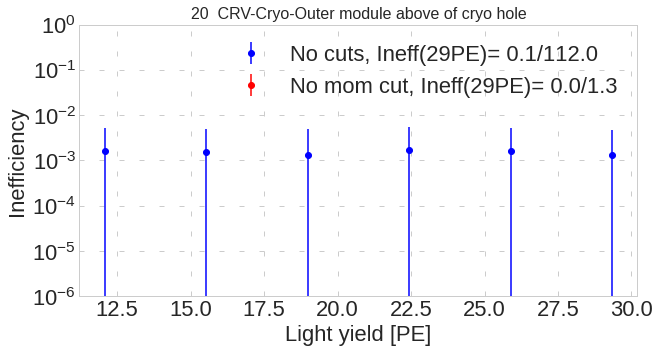

In [13]:
for crvSectorNumber in range(0,21):
  plt.figure()
  crvSectorName = crvSectorNames[crvSectorNumber]
  df_ = dfIneff.query('crvSectorName==@crvSectorName & cut=="No cuts"')
  plt.errorbar(df_['lyield'], df_['ineff'], yerr=df_['ineffErr'], ls='None', color='Blue', marker='o', label='No cuts, Ineff(29PE)= %.1f/%.1f'% (df_['nonvetoed'].iloc[0], df_['all'].iloc[0]) )
  df_ = dfIneff.query('crvSectorName==@crvSectorName & cut=="No mom cut"')
  plt.errorbar(df_['lyield'], df_['ineff'], yerr=df_['ineffErr'], ls='None', color='Red', marker='o', label='No mom cut, Ineff(29PE)= %.1f/%.1f'% (df_['nonvetoed'].iloc[0], df_['all'].iloc[0]) )

  plt.title(utils.CRV_SECTOR_NAMES_V7[crvSectorName], fontsize=16)
  plt.yscale('log')
  plt.xlabel('Light yield [PE]')
  plt.ylabel('Inefficiency')
  plt.ylim(1e-6, 1)
  plt.locator_params(axis="y", numticks=10)
  plt.legend(loc='upper right')